## IMPORTING CLEAN DATA & LIBRARIES

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# for parallelization
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()

# models 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn import metrics

%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

X_train = X_train.toarray()
X_test  = X_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reducing Number of Datapoints for better model training times
X_train = np.resize(X_train, (500000, 1000))
y_train = np.resize(y_train, (500000,))
X_test  = np.resize(X_test, (214000, 1000))
y_test  = np.resize(y_test, (214000,))

# Note: Still stratified 

In [50]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Naive Bayes

### DEFAULT


MODEL: Naive Bayes
Accuracy:  0.7003457943925233
Precision:  0.6777160693680008
Recall:  0.7633835479376478
F1 Score:  0.7180035180299031


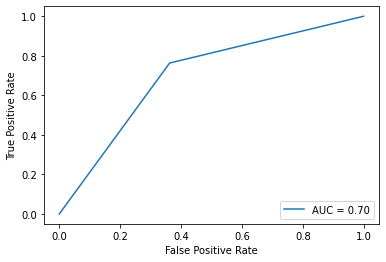

In [51]:
nb = GaussianNB()

with parallel_backend("ray"):
    nb.fit(X_train, y_train)

y_predict = nb.predict(X_test)
evaluate(y_test, y_predict, 'Naive Bayes')

### PARAMETER TUNING

In [52]:
# TODO ARYAN